In [1]:
import optuna
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [8]:
marketing_df = pd.read_csv('../2. data_after_txt_proc/bank_marketing_data_after_txt_proc.csv')
personal_df = pd.read_csv('../2. data_after_txt_proc/Bank_Personal_Loan_Modelling_after_txt_proc.csv')

# marketing_df

In [9]:
X_m, y_m = marketing_df.drop(columns='deposit'), marketing_df.deposit

In [10]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42)

In [32]:
def objective_m(trial):
    # Гиперпараметры для оптимизации
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])

    # Ограничение выбора solver для 'elasticnet'
    if penalty == 'elasticnet':
        solver = 'saga'
    else:
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    # Параметр l1_ratio для ElasticNet
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    # Создание пайплайна
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            l1_ratio=l1_ratio if penalty == 'elasticnet' else None,
            max_iter=5000,
            random_state=42
        ))
    ])

    # Кросс-валидация
    score = cross_val_score(model, X_train_m, y_train_m, cv=5, scoring='accuracy').mean()
    return score

In [33]:
%%time
study_m = optuna.create_study(direction='maximize')
study_m.optimize(objective_m, n_trials=50)

[I 2024-12-02 16:24:17,310] A new study created in memory with name: no-name-5928cc0a-f9d2-438b-ac3a-3c8c1abef9bd
C:\Users\mitay\AppData\Local\Temp\ipykernel_8268\120367745.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-12-02 16:24:17,471] Trial 0 finished with value: 0.8079297116382949 and parameters: {'C': 0.9232000917811571, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8079297116382949.
C:\Users\mitay\AppData\Local\Temp\ipykernel_8268\120367745.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-12-02 16:24:17,689] Trial 1 finished 

CPU times: total: 55.1 s
Wall time: 55.8 s


In [34]:
print("Best hyperparameters:", study_m.best_params)
print("Best cross-validation score:", study_m.best_value)

Best hyperparameters: {'C': 0.6555858377352966, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation score: 0.8081536130689677


In [35]:
best_model_m = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        C=study_m.best_params['C'],
        penalty=study_m.best_params['penalty'],
        solver=study_m.best_params['solver'],
        l1_ratio=study_m.best_params.get('l1_ratio', None),  # Проверяем наличие l1_ratio
        max_iter=1000,
        random_state=42
    ))
])

In [36]:
best_model_m.fit(X_train_m, y_train_m)
test_score_m = best_model_m.score(X_test_m, y_test_m)
print("Test accuracy:", test_score_m)

Test accuracy: 0.7971339005821765


Feature importance (sorted):
duration: 1.8227
poutcome_success: 0.6460
contact_unknown: 0.5192
housing: 0.4077
campaign: 0.3016
loan: 0.2050
job_retired: 0.1733
poutcome_unknown: 0.1714
education_tertiary: 0.1524
job_student: 0.1426
job_admin.: 0.1098
marital_married: 0.0883
education_primary: 0.0867
balance: 0.0827
month: 0.0651
day: 0.0465
job_entrepreneur: 0.0428
job_self-employed: 0.0381
job_technician: 0.0376
previous: 0.0350
job_blue-collar: 0.0271
default: 0.0228
age: 0.0214
poutcome_other: 0.0168
contact_cellular: 0.0116
education_unknown: 0.0116
marital_single: 0.0104
job_services: 0.0094
job_housemaid: 0.0077
job_unemployed: 0.0008
pdays: 0.0003
marital_divorced: 0.0000
education_secondary: 0.0000
contact_telephone: 0.0000
poutcome_failure: 0.0000
job_management: 0.0000
job_unknown: 0.0000


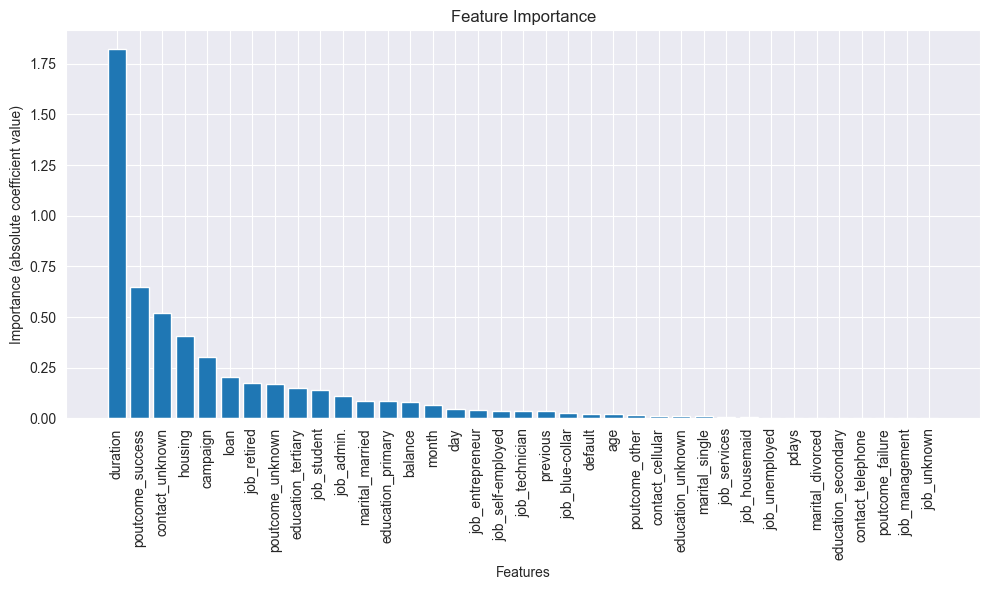

In [44]:
import numpy as np
import matplotlib.pyplot as plt

feature_names_m = [i for i in X_m.columns]  # Для make_classification

# Оценка модели с оптимизированными гиперпараметрами
best_model_m.fit(X_train_m, y_train_m)

# Извлечение коэффициентов модели
clf_m = best_model_m.named_steps['clf']
if hasattr(clf_m, 'coef_'):
    feature_importances_m = np.abs(clf_m.coef_[0])  # Для бинарной классификации
    feature_indices_m = np.argsort(feature_importances_m)[::-1]

    # Вывод важности признаков
    print("Feature importance (sorted):")
    for idx in feature_indices_m:
        print(f"{feature_names_m[idx]}: {feature_importances_m[idx]:.4f}")

    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances_m)), feature_importances_m[feature_indices_m])
    plt.xticks(range(len(feature_importances_m)), [feature_names_m[i] for i in feature_indices_m], rotation=90)
    plt.title("Feature Importance")
    plt.xlabel("Features")
    plt.ylabel("Importance (absolute coefficient value)")
    plt.tight_layout()
    plt.show()
else:
    print("Model does not provide feature coefficients.")


# Personal_df

In [45]:
X_p, y_p = personal_df.drop(columns='Personal Loan'), personal_df['Personal Loan']

In [46]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)


In [48]:
def objective_p(trial):
    # Гиперпараметры для оптимизации
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])

    # Ограничение выбора solver для 'elasticnet'
    if penalty == 'elasticnet':
        solver = 'saga'
    else:
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    # Параметр l1_ratio для ElasticNet
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    # Создание пайплайна
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            l1_ratio=l1_ratio if penalty == 'elasticnet' else None,
            max_iter=5000,
            random_state=42
        ))
    ])

    # Кросс-валидация
    score = cross_val_score(model, X_train_p, y_train_p, cv=5, scoring='accuracy').mean()
    return score

In [49]:
study_p = optuna.create_study(direction='maximize')
study_p.optimize(objective_p, n_trials=50)

[I 2024-12-02 16:37:25,435] A new study created in memory with name: no-name-efefc244-6c53-4645-a324-25c92fe4c1e9
C:\Users\mitay\AppData\Local\Temp\ipykernel_8268\3461054765.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-12-02 16:37:25,495] Trial 0 finished with value: 0.9190000000000002 and parameters: {'C': 0.00011407634861181552, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.9190000000000002.
C:\Users\mitay\AppData\Local\Temp\ipykernel_8268\3461054765.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-12-02 16:37:25,857] Trial 1 fin

In [50]:
print("Best hyperparameters:", study_p.best_params)
print("Best cross-validation score:", study_p.best_value)

Best hyperparameters: {'C': 0.3670322707634479, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation score: 0.95175


In [51]:
best_model_p = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        C=study_m.best_params['C'],
        penalty=study_m.best_params['penalty'],
        solver=study_m.best_params['solver'],
        l1_ratio=study_m.best_params.get('l1_ratio', None),  # Проверяем наличие l1_ratio
        max_iter=5000,
        random_state=42
    ))
])

In [53]:
best_model_p.fit(X_train_p, y_train_p)
test_score_p = best_model_p.score(X_test_p, y_test_p)
print("Test accuracy:", test_score_p)

Test accuracy: 0.955


Feature importance (sorted):
Income: 2.4019
Education: 1.3245
CD Account: 0.8781
Family: 0.8100
CreditCard: 0.5355
Online: 0.2875
Securities Account: 0.2497
CCAvg: 0.1761
Experience: 0.1193
ZIP Code: 0.0805
Mortgage: 0.0485
Age: 0.0000


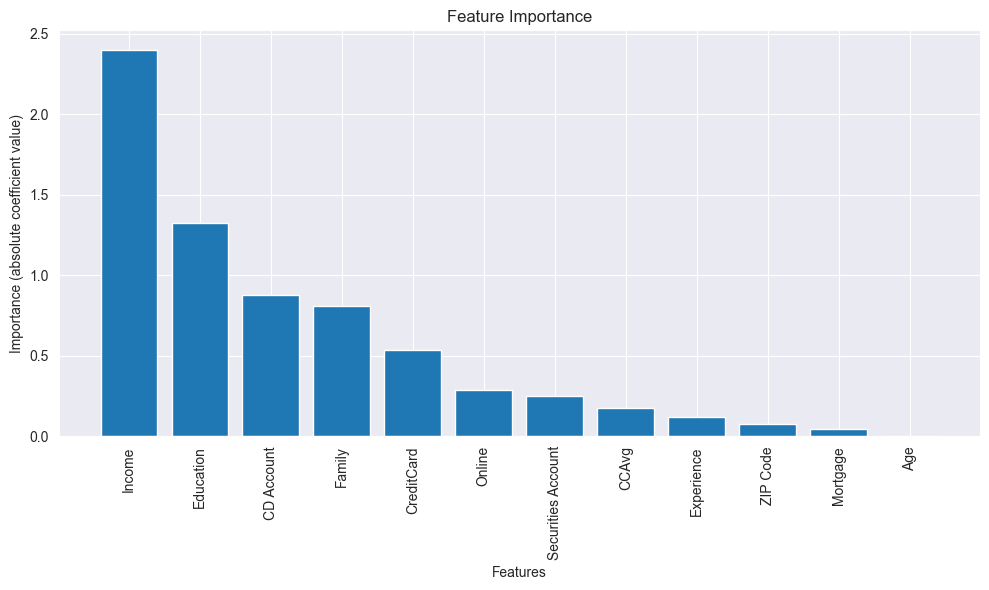

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Названия признаков
feature_names_p = [i for i in X_p.columns]  # Для make_classification

# Оценка модели с оптимизированными гиперпараметрами
best_model_p.fit(X_train_p, y_train_p)

# Извлечение коэффициентов модели
clf_p = best_model_p.named_steps['clf']
if hasattr(clf_p, 'coef_'):
    feature_importances_p = np.abs(clf_p.coef_[0])  # Для бинарной классификации
    feature_indices_p = np.argsort(feature_importances_p)[::-1]

    # Вывод важности признаков
    print("Feature importance (sorted):")
    for idx in feature_indices_p:
        print(f"{feature_names_p[idx]}: {feature_importances_p[idx]:.4f}")

    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances_p)), feature_importances_p[feature_indices_p])
    plt.xticks(range(len(feature_importances_p)), [feature_names_p[i] for i in feature_indices_p], rotation=90)
    plt.title("Feature Importance")
    plt.xlabel("Features")
    plt.ylabel("Importance (absolute coefficient value)")
    plt.tight_layout()
    plt.show()
else:
    print("Model does not provide feature coefficients.")
